In [1]:
# Install the Kaggle library
!pip install kaggle

In [3]:
import os

# Define the path for the Kaggle API key
kaggle_dir = os.path.expanduser('~/.kaggle')
kaggle_json_path = os.path.join(kaggle_dir, 'kaggle.json')

os.makedirs(kaggle_dir, exist_ok=True)

if os.path.exists('/content/kaggle.json'):
    !mv /content/kaggle.json {kaggle_json_path}
    # Set permissions for the kaggle.json file
    !chmod 600 {kaggle_json_path}
    print(f"Moved and secured {kaggle_json_path}")
else:
    print("Error: kaggle.json not found in /content/. Please ensure it's uploaded.")

# Define the dataset path on Kaggle
dataset_name = 'yudhaislamisulistya/plants-type-datasets'

# Download the dataset
print(f"Downloading dataset: {dataset_name}...")
!kaggle datasets download -d {dataset_name}

# List contents to find the downloaded zip file
print("Downloaded files:")
!ls

zip_file_name = dataset_name.split('/')[-1] + '.zip'

# Unzip the dataset into a new directory
output_dir = dataset_name.split('/')[-1]
print(f"Unzipping {zip_file_name} into {output_dir}/")
!mkdir -p {output_dir}
!unzip -q {zip_file_name} -d {output_dir}

print("Dataset download and extraction complete!")
print(f"Contents of {output_dir}/:")
!ls {output_dir}/

Moved and secured /root/.kaggle/kaggle.json
Dataset URL: https://www.kaggle.com/datasets/yudhaislamisulistya/plants-type-datasets
License(s): copyright-authors
 93% 870M/937M [00:09<00:02, 32.8MB/s]
100% 937M/937M [00:09<00:00, 100MB/s] 
Downloaded files:
plants-type-datasets  plants-type-datasets.zip	sample_data
Unzipping plants-type-datasets.zip into plants-type-datasets/
Dataset download and extraction complete!
Contents of plants-type-datasets/:
split_ttv_dataset_type_of_plants


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_small
from transformers import BertModel, BertConfig


# Lightweight Vision Encoder - MobileViT Tiny inspired substitute
class VisionEncoder(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        # Use MobileNetV3 Small as an efficient backbone substitute (MobileViT native is complex)
        self.backbone = mobilenet_v3_small(pretrained=True)
        # Projection head to embedding dimension
        self.proj = nn.Linear(576, embed_dim)  # 576 is output from MobileNetV3 last layer

    def forward(self, x):
        x = self.backbone.features(x)  # Shape: [B, c, H, W]
        x = F.adaptive_avg_pool2d(x, 1).flatten(1)  # [B, c]
        x = self.proj(x)
        x = F.normalize(x, dim=-1)  # Normalize embeddings to unit length
        return x


# Lightweight Text Encoder - Distilled small transformer
class TextEncoder(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        # Use BERT small config as a distilled text encoder surrogate (e.g., 6 layers)
        config = BertConfig(
            hidden_size=384,
            num_hidden_layers=6,
            num_attention_heads=6,
            intermediate_size=1536,
            max_position_embeddings=77,
            vocab_size=28996  # Typical BERT tokenizer vocab size
        )
        self.bert = BertModel(config)
        self.proj = nn.Linear(384, embed_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output  # CLS token representation
        x = self.proj(pooled)
        x = F.normalize(x, dim=-1)
        return x


# FastLightCLIP: Combined multimodal model
class FastLightCLIP(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        self.vision_encoder = VisionEncoder(embed_dim)
        self.text_encoder = TextEncoder(embed_dim)
        self.temperature = nn.Parameter(torch.tensor(1.0))

    def forward(self, images, input_ids, attention_mask):
        image_features = self.vision_encoder(images)
        text_features = self.text_encoder(input_ids, attention_mask)

        # Contrastive similarity logits
        logits_per_image = (image_features @ text_features.t()) * self.temperature.exp()
        logits_per_text = logits_per_image.t()

        return logits_per_image, logits_per_text


# Example contrastive loss (InfoNCE)
def clip_loss(logits_per_image, logits_per_text):
    batch_size = logits_per_image.size(0)
    labels = torch.arange(batch_size).to(logits_per_image.device)
    loss_img = F.cross_entropy(logits_per_image, labels)
    loss_txt = F.cross_entropy(logits_per_text, labels)
    return (loss_img + loss_txt) / 2


# Example training usage setup
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = FastLightCLIP().to(device)

    # Dummy data (replace with real image tensor and tokenized text)
    dummy_images = torch.randn(4, 3, 224, 224).to(device)  # Batch of 4 images
    dummy_input_ids = torch.randint(0, 28996, (4, 77)).to(device)  # Batch of 4 token sequences
    dummy_attention_mask = torch.ones(4, 77).to(device)

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Forward pass
    logits_per_image, logits_per_text = model(dummy_images, dummy_input_ids, dummy_attention_mask)
    loss = clip_loss(logits_per_image, logits_per_text)

    print(f"Loss: {loss.item()}")

    # Backward and optimize
    loss.backward()
    optimizer.step()




/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 63.2MB/s]


Loss: 1.4197309017181396


In [6]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

# ==========================
# CONFIG
# ==========================
BASE_DIR = Path("plants-type-datasets/split_ttv_dataset_type_of_plants/Train_Set_Folder")
FEATURES_PATH = Path("fastlightclip_image_features.npy")
PATHS_PATH = Path("fastlightclip_image_paths.npy")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

vision_encoder = VisionEncoder(embed_dim=256).to(DEVICE)
vision_encoder.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

Using device: cuda


In [7]:
def get_image_paths(base_dir: Path):
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp"}
    all_paths = []
    for root, _, files in os.walk(base_dir):
        for f in files:
            if Path(f).suffix.lower() in exts:
                all_paths.append(str(Path(root) / f))
    return all_paths


@torch.no_grad()
def extract_feature(img_path: str) -> np.ndarray:
    img = Image.open(img_path).convert("RGB")
    x = preprocess(img).unsqueeze(0).to(DEVICE)  # [1, 3, 224, 224]
    emb = vision_encoder(x)                      # [1, 256], already L2-normalized
    return emb.cpu().numpy().flatten()           # [256]


def build_feature_index(force_recompute: bool = False):
    if FEATURES_PATH.exists() and PATHS_PATH.exists() and not force_recompute:
        print("Loading cached features...")
        features = np.load(FEATURES_PATH)
        img_paths = np.load(PATHS_PATH, allow_pickle=True)
        print("Loaded:", features.shape, "embeddings")
        return features, img_paths

    print("Collecting image paths...")
    img_paths = get_image_paths(BASE_DIR)
    print(f"Found {len(img_paths)} images.")

    features = []
    for i, p in enumerate(img_paths, 1):
        try:
            feat = extract_feature(p)
            features.append(feat)
        except Exception as e:
            print(f"Error on {p}: {e}")
            continue

        if i % 100 == 0:
            print(f"Processed {i}/{len(img_paths)} images")

    features = np.stack(features, axis=0)
    img_paths = np.array(img_paths, dtype=object)

    np.save(FEATURES_PATH, features)
    np.save(PATHS_PATH, img_paths)

    print("Saved features:", features.shape)
    return features, img_paths


# Build or load the index
features, img_paths = build_feature_index()


Found 23972 images.
Processed 100/23972 images
Processed 200/23972 images
Processed 300/23972 images
Processed 400/23972 images
Processed 500/23972 images
Processed 600/23972 images
Processed 700/23972 images
Processed 800/23972 images
Processed 900/23972 images
Processed 1000/23972 images
Processed 1100/23972 images
Processed 1200/23972 images
Processed 1300/23972 images
Processed 1400/23972 images
Processed 1500/23972 images
Processed 1600/23972 images
Processed 1700/23972 images
Processed 1800/23972 images
Processed 1900/23972 images
Processed 2000/23972 images
Processed 2100/23972 images
Processed 2200/23972 images
Processed 2300/23972 images
Processed 2400/23972 images
Processed 2500/23972 images
Processed 2600/23972 images
Processed 2700/23972 images
Processed 2800/23972 images
Processed 2900/23972 images
Processed 3000/23972 images
Processed 3100/23972 images
Processed 3200/23972 images
Processed 3300/23972 images
Processed 3400/23972 images
Processed 3500/23972 images
Processed

In [8]:
@torch.no_grad()
def search_similar_images(query_image_path: str, top_k: int = 5):
    query_feat = extract_feature(query_image_path)  # [256], L2-normalized
    # cosine similarity = dot product because all are normalized
    sims = features @ query_feat                    # [N]
    top_indices = np.argsort(-sims)[:top_k]
    return top_indices, sims[top_indices]


def show_results(query_image_path: str, top_k: int = 5):
    idxs, sims = search_similar_images(query_image_path, top_k)

    plt.figure(figsize=(3 * (top_k + 1), 4))

    # Query
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(Image.open(query_image_path).convert("RGB"))
    plt.title("Query")
    plt.axis("off")

    # Retrieved images
    for i, (idx, sim) in enumerate(zip(idxs, sims), start=2):
        plt.subplot(1, top_k + 1, i)
        img = Image.open(img_paths[idx]).convert("RGB")
        plt.imshow(img)
        plt.title(f"{sim:.3f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


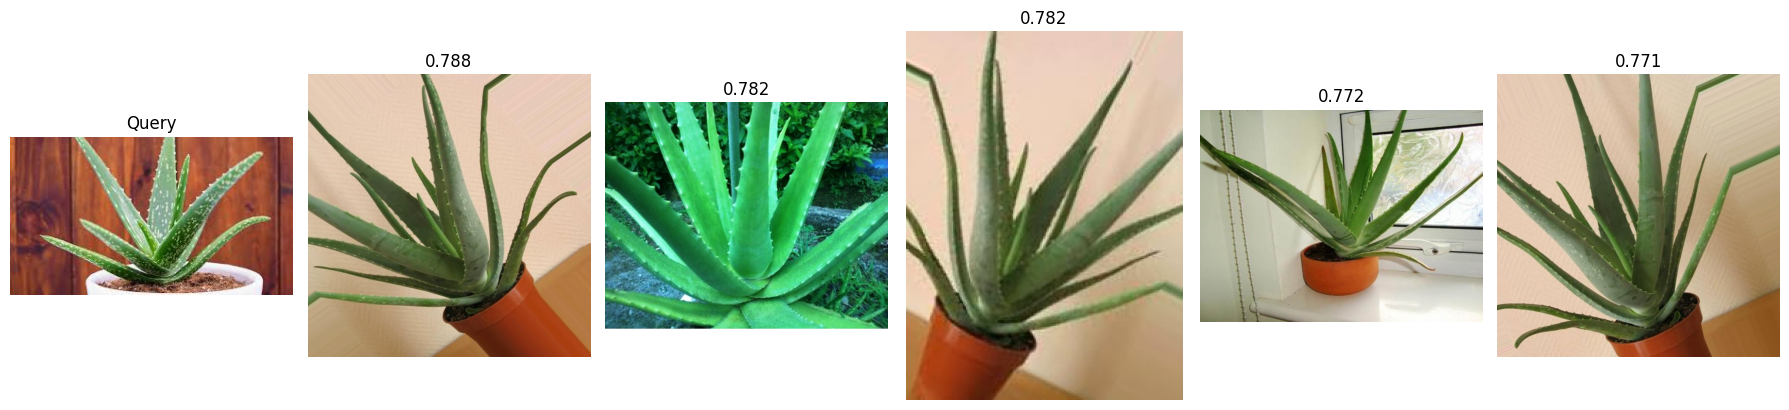

In [13]:
if __name__ == "__main__":
    QUERY_IMAGE_PATH = (
        "images.jpeg"
    )

    show_results(QUERY_IMAGE_PATH, top_k=5)

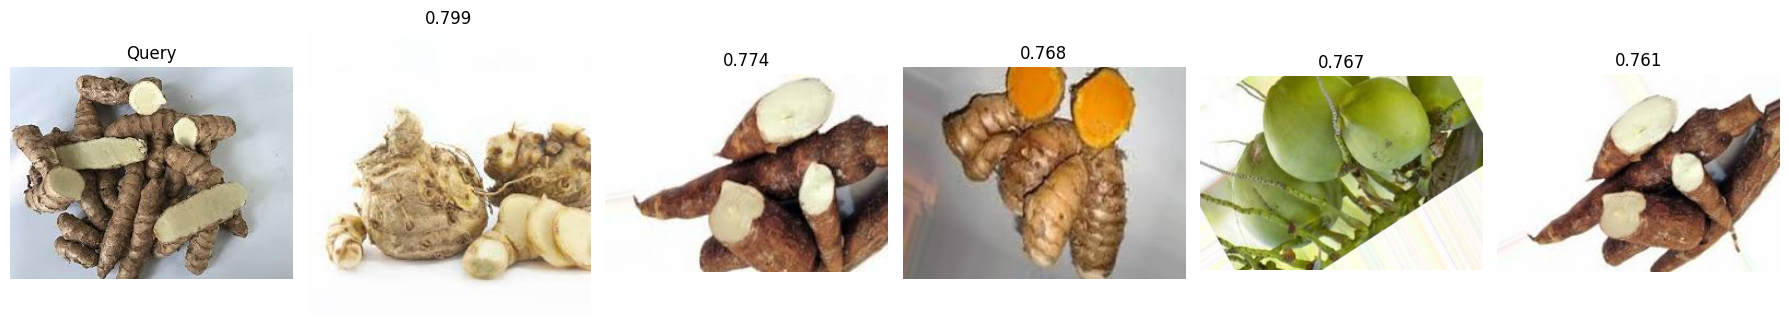

In [15]:
if __name__ == "__main__":
    QUERY_IMAGE_PATH = (
        "/content/images (1).jpeg"
    )

    show_results(QUERY_IMAGE_PATH, top_k=5)

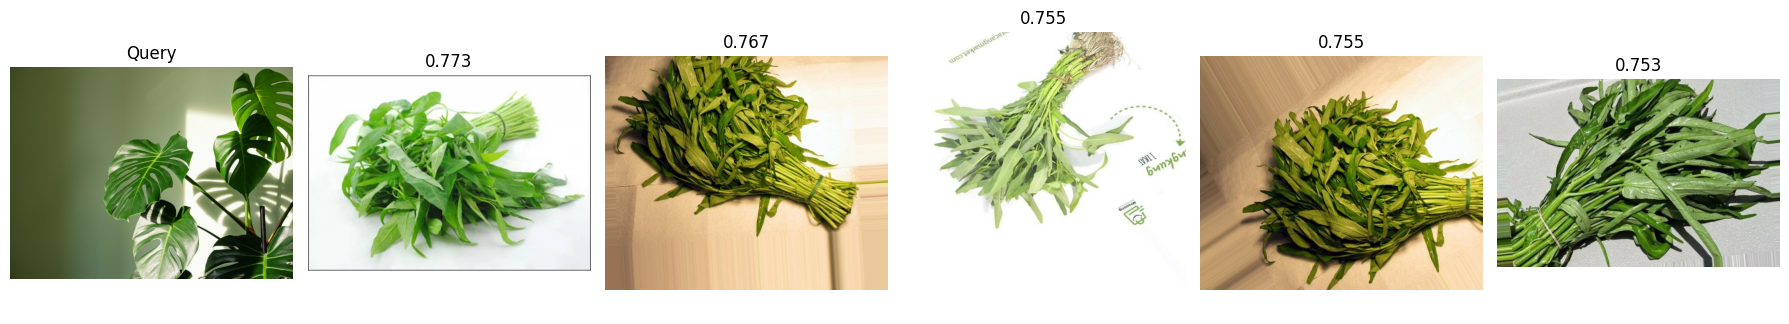

In [16]:
#test image of plant of which relevent images are not in dataset
if __name__ == "__main__":
    QUERY_IMAGE_PATH = (
        "/content/plant2.jpg"
    )

    show_results(QUERY_IMAGE_PATH, top_k=5)